                    load      price  temperature  dayofweek  is_weekend  \
time                                                                      
2018-11-01  55435.677083  47.913333     7.237500          3           0   
2018-11-02  58741.354167  54.768750     7.920833          4           0   
2018-11-03  52306.989583   0.000000     6.400000          5           1   
2018-11-04  48647.406250   0.000000     8.016667          6           1   
2018-11-05  60938.635417  57.194167     9.000000          0           0   

            is_holiday  is_low  
time                            
2018-11-01           0       0  
2018-11-02           0       0  
2018-11-03           0       0  
2018-11-04           0       0  
2018-11-05           0       0  
Number of data points in the interval: 1826
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3390.223, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] inter

c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Summary:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1369
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 7)   Log Likelihood                -229.852
Date:                             Sun, 26 Jan 2025   AIC                            487.704
Time:                                     19:18:22   BIC                            560.800
Sample:                                 01-01-2019   HQIC                           515.061
                                      - 09-30-2022                                         
Covariance Type:                               opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
is_weekend        -1.1814      0.051    -23.150      0.000      -1.281      -1.081

[]

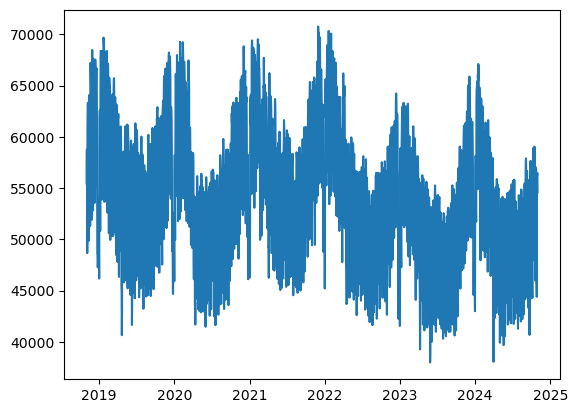

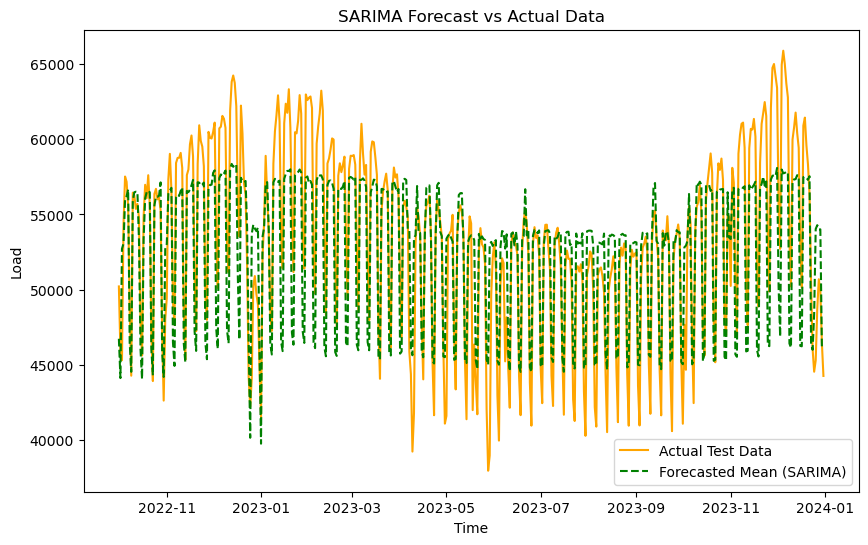

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
import math as mat

# Load CSV file
file_path = r"C:\...\.\avg_hourly_merged_data.csv" # Use the avg_hourly_processed_data_with_features found in the Data file
daily_df = pd.read_csv(file_path, parse_dates=['time'], dayfirst=True)

# Convert 'time' column to datetime and set as index
daily_df['time'] = pd.to_datetime(daily_df['time'])
daily_df.set_index('time', inplace=True)
plt.plot(daily_df.index, daily_df['load'])
# Add new features To capture seasonal effects
#daily_df['hour'] = daily_df.index.hour  # To extract hour of the day
daily_df['dayofweek'] = daily_df.index.dayofweek  # To extract day of the week (0=Monday, 6=Sunday)
daily_df['is_weekend'] = daily_df['dayofweek'] >= 5  # returns a boolean (i-e. 1 for weekends (Saturday/Sunday))
daily_df['is_weekend'] = daily_df['is_weekend'].astype(int)

# to capture the holiday effects 
holidays = [
            '2020-01-01', '2020-12-25',
            '2021-01-01', '2021-12-25',
            '2022-01-01', '2022-12-25', 
            '2023-01-01', '2023-12-25']  
daily_df['is_holiday'] = daily_df.index.date.astype(str)  
daily_df['is_holiday'] = daily_df['is_holiday'].isin(holidays)  # we needed to use .isin() on the pandas Series
daily_df['is_holiday'] = daily_df['is_holiday'].astype(int)


# To generate the peak season step
pick_season = [
    ('2021-12-01', '2022-01-31'),  # Holiday range 1
    ('2022-12-01', '2023-01-31'),  # Holiday range 2
    ('2023-12-01', '2023-12-31')   # Holiday range 3
]

high = []
for start, end in pick_season:
    high += pd.date_range(start=start, end=end, freq='D').strftime('%Y-%m-%d').tolist()

# To convert your datetime index to string for comparison
daily_df['is_low'] = daily_df.index.date.astype(str)

# To mark the holiday dates directly in the 'is_holiday' column without using isin
daily_df['is_low'] = daily_df['is_low'].apply(lambda x: 1 if x in high else 0) # create boolean

print(daily_df.head()) 

load_time_temp=daily_df['temperature']*daily_df['load']
y=np.mean(load_time_temp)
z = load_time_temp.quantile(0.80)
daily_df['load_time_temp']=load_time_temp.apply(lambda x: 1 if x<=z else 0)
daily_df['is_high_load']=daily_df['load'].apply(lambda x: 1 if x>55000 else 0)

# To take a subset of the data
daily_df_subset = daily_df.loc['2019-01-01':'2023-12-31', ['load', 'is_weekend', 'is_holiday', 'is_low', 'price', 'temperature', 'is_high_load', 'load_time_temp']] # removed 'hour'
# To count the number of data points in the subset
num_data_points = daily_df_subset.shape[0]
x=mat.floor(num_data_points*0.75)
print(f"Number of data points in the interval: {num_data_points}")

# To define training and testing datasets
train_data = daily_df_subset['load'][:x]  # Use only the first 2000 observations for training 
test_data = daily_df_subset['load'][x:]  # Use the rest for testing

# To standardize the data (Reshaping required for StandardScaler)
scaler = StandardScaler()

# To correct reshaping: transform into 2D array for StandardScaler
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1)).flatten()

# Then we use auto_arima to find optimal SARIMA parameters with external regressors
auto_model = auto_arima(
    scaled_train_data, 
    seasonal=True, 
    d=1,  # differentiating
    m=7, # daily data
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True,
    exogenous=daily_df_subset[[ 'is_weekend', 'is_holiday', 'is_low','price', 'temperature', 'is_high_load','load_time_temp']][:x]  # Add external regressors # removed 'hour'
)
print(auto_model.summary())

# To extract the optimal parameters from auto_arima
p, d, q = auto_model.order
P, D, Q, s = auto_model.seasonal_order


# To fit the SARIMA model with external regressors (using the training data)
mod = SARIMAX(
    scaled_train_data, 
    order=(p, d, q), 
    seasonal_order=(P, D, Q, s), 
    exog=daily_df_subset[[ 'is_weekend', 'is_holiday', 'is_low', 'price', 'temperature', 'is_high_load','load_time_temp']][:x]  # External regressors for training data 
)
sarima_result = mod.fit(disp=False)

# print SARIMA model summary
print("SARIMA Summary:")
print(sarima_result.summary())

# To forecast with SARIMA
forecast = sarima_result.get_forecast(steps=len(scaled_test_data), exog=daily_df_subset[[ 'is_weekend', 'is_holiday', 'is_low', 'price', 'temperature','is_high_load','load_time_temp']][x:]) # Made change here # removed 'hour'
forecast_mean = forecast.predicted_mean

# To rescale SARIMA forecast mean to original scale
forecast_mean_rescaled = scaler.inverse_transform(forecast_mean.values.reshape(-1, 1)).flatten()

# To escale actual test data
test_rescaled = scaler.inverse_transform(scaled_test_data.reshape(-1, 1)).flatten()

# Tee plotting: forecast vs actual data
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_rescaled, label='Actual Test Data', color='orange')
plt.plot(test_data.index, forecast_mean_rescaled, label='Forecasted Mean (SARIMA)', color='green', linestyle='--')
plt.title('SARIMA Forecast vs Actual Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
# plt.savefig('sarima_forecast_vs_actual.png')
plt.plot()